<a href="https://colab.research.google.com/github/Rup28/Solar_Flare/blob/main/Solar_Flare_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2022-08-30 05:25:15--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.009s  

2022-08-30 05:25:15 (7.34 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



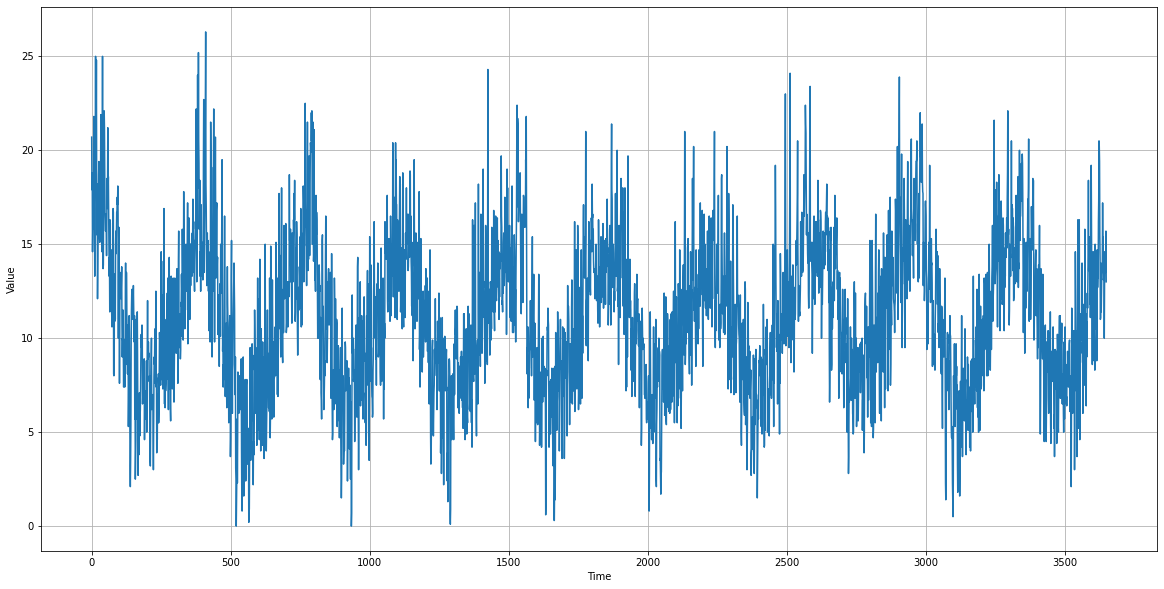

In [ ]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(20, 10))
plot_series(time, series)

In [ ]:
import pandas as pd
sunspots_daily = pd.read_csv('/tmp/daily-min-temperatures.csv')
sunspots_daily.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [ ]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 64
batch_size = 100
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
and_i_stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'auto')

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.fit(train_set,epochs=250,callbacks=[and_i_stop])

Epoch 1/250
10/10 [==============================] - 16s 67ms/step - loss: 36.8870 - mae: 37.3864
Epoch 2/250
10/10 [==============================] - 0s 28ms/step - loss: 36.0424 - mae: 36.5417
Epoch 3/250
10/10 [==============================] - 0s 30ms/step - loss: 34.8388 - mae: 35.3380
Epoch 4/250
10/10 [==============================] - 0s 30ms/step - loss: 33.5044 - mae: 34.0034
Epoch 5/250
10/10 [==============================] - 0s 30ms/step - loss: 32.1190 - mae: 32.6180
Epoch 6/250
10/10 [==============================] - 0s 31ms/step - loss: 30.7081 - mae: 31.2069
Epoch 7/250
10/10 [==============================] - 0s 30ms/step - loss: 29.2847 - mae: 29.7832
Epoch 8/250
10/10 [==============================] - 0s 31ms/step - loss: 27.8493 - mae: 28.3475
Epoch 9/250
10/10 [==============================] - 0s 29ms/step - loss: 26.4098 - mae: 26.9077
Epoch 10/250
10/10 [==============================] - 0s 32ms/step - loss: 24.9695 - mae: 25.4671
Epoch 11/250
10/10 [========

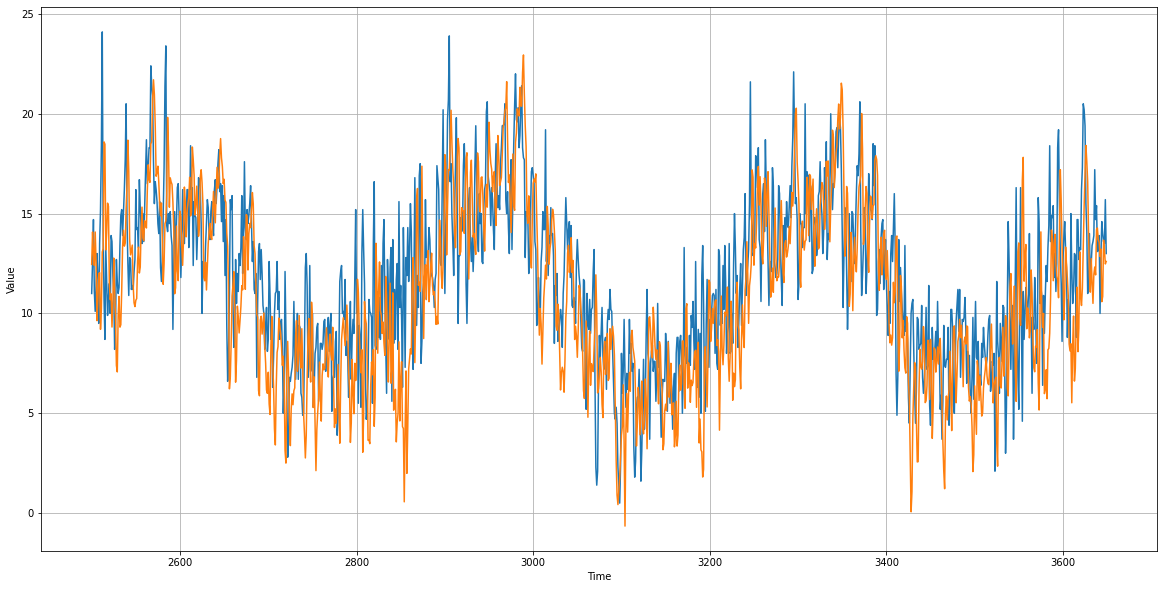

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(20, 10))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())
print(rnn_forecast)

2.8091488
[12.457928 14.077509 12.994674 ... 13.165561 12.478422 12.602994]


In [ ]:
df_sunspot_prediction = pd.DataFrame(data = {'Time_step':time_valid,
                                             'Observed': x_valid,
                                             'predicted':rnn_forecast},
                                    )

In [ ]:

df_sunspot_prediction.tail()

,Time_step,Observed,predicted
1145,3645,14.0,10.846571
1146,3646,13.6,13.669252
1147,3647,13.5,13.165561
1148,3648,15.7,12.478422
1149,3649,13.0,12.602994


In [ ]:
df_sunspot_prediction.head()

,Time_step,Observed,predicted
0,2500,11.0,12.457928
1,2501,12.6,14.077509
2,2502,14.7,12.994674
3,2503,11.1,12.403932
4,2504,10.1,14.078951
